# <center> Projet EXCEL MASTER MEDAS  <br> Automatisation d'un reporting avec Python </center>

Documentation Openpxyl : https://openpyxl.readthedocs.io/en/stable/tutorial.html

# Importation des données

In [1]:
import csv
import openpyxl
from openpyxl import Workbook   
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook 
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill
from openpyxl.chart import BarChart, Reference
from openpyxl.styles import Font, Border, Side
from openpyxl.styles import Alignment
from openpyxl.chart.label import DataLabelList
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.utils import quote_sheetname
from openpyxl.utils.cell import coordinate_from_string, column_index_from_string
import pandas as pd

# Lecture du fichier CSV et création du dataframe
df = pd.read_csv("video_games_sales.csv")
# Affichage de la structure du dataframe
df.info()
# Affichage des 5 premières lignes du dataframe
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Voici à quoi ressemble notre jeu de données, il a été trouvé sur Kaggle et contient l'ensemble des ventes de jeux vidéos sur plusieurs plateformes en fonction des régions du monde. 

# Traitement des données

**On observe ici plusieurs problèmes :**
    

1) Nous allons traiter les potentielles données manquantes <br>
2) les éléments de la colonnes **"year"** n'ont pas la bonne forme, il faut supprimer le **".0"** à la fin de chaque ligne. <br>
3) les éléments des colonnes **"na_sales"**, **"eu_sales"**, **"jp_sales"**, **"other_sales"** utilisent un **"."** pour délimiter la partie entière de la partie décimale. Ce n'est pas un problème (bien au contraire) pour Python cependant pour Excel, il faut une virgule. J'utiliserai le paramètre **decimal = ','** lors des exports en csv/xlsx. <br>


## 1) Données manquantes 

In [2]:
# Afficher les données manquantes par colonnes
print(df.isna().sum(axis=0))

rank              0
name              0
platform          0
year            271
genre             0
publisher        58
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
global_sales      0
dtype: int64


Nous avons 271 valeurs manquantes pour l'année et 58 concernant l'éditeur. 
Nous allons regarder ce qu'elles contiennent.

In [3]:
top_10_missing_years = df[df['year'].isnull()].sort_values(by='global_sales', ascending=False).head(10)
print(top_10_missing_years)

     rank                                         name platform  year  \
179   180                              Madden NFL 2004      PS2   NaN   
377   378                             FIFA Soccer 2004      PS2   NaN   
431   432                   LEGO Batman: The Videogame      Wii   NaN   
470   471                   wwe Smackdown vs. Raw 2006      PS2   NaN   
607   608                               Space Invaders     2600   NaN   
624   625                                    Rock Band     X360   NaN   
649   650     Frogger's Adventures: Temple of the Frog      GBA   NaN   
652   653  LEGO Indiana Jones: The Original Adventures      Wii   NaN   
711   713                               Call of Duty 3      Wii   NaN   
782   784                                    Rock Band      Wii   NaN   

         genre                               publisher  na_sales  eu_sales  \
179     Sports                         Electronic Arts      4.26      0.26   
377     Sports                         E

Heureusement pour nous, ce sont plus ou moins des jeux peu vendus. Malheureusement, nous ne pouvons pas retrouver l'information de la date de sortie de manière simple et rapide, nous allons donc les supprimer. De plus, conserver ces données pourrait poser des problèmes dans le reporting à cause des valeurs manquantes. 

In [4]:
top_10_missing_publisher = df[df['publisher'].isnull()].sort_values(by='global_sales', ascending=False).head(10)
print(top_10_missing_publisher)

      rank                                               name platform  \
470    471                         wwe Smackdown vs. Raw 2006      PS2   
1303  1305                                     Triple Play 99       PS   
1662  1664       Shrek / Shrek 2 2-in-1 Gameboy Advance Video      GBA   
2222  2224                                 Bentley's Hackpack      GBA   
3159  3161  Nicktoons Collection: Game Boy Advance Video V...      GBA   
3166  3168  SpongeBob SquarePants: Game Boy Advance Video ...      GBA   
3766  3768  SpongeBob SquarePants: Game Boy Advance Video ...      GBA   
4145  4147                                 Sonic the Hedgehog      PS3   
4526  4528  The Fairly Odd Parents: Game Boy Advance Video...      GBA   
4635  4637  The Fairly Odd Parents: Game Boy Advance Video...      GBA   

        year     genre publisher  na_sales  eu_sales  jp_sales  other_sales  \
470      NaN  Fighting       NaN      1.57      1.02       0.0         0.41   
1303     NaN    Sports     

Même conclusion que sur la colonne "year"

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16291 non-null  int64  
 1   name          16291 non-null  object 
 2   platform      16291 non-null  object 
 3   year          16291 non-null  float64
 4   genre         16291 non-null  object 
 5   publisher     16291 non-null  object 
 6   na_sales      16291 non-null  float64
 7   eu_sales      16291 non-null  float64
 8   jp_sales      16291 non-null  float64
 9   other_sales   16291 non-null  float64
 10  global_sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


## 2) Traitement de la colonne "year"

Je vais tout simplement convertir la colonne "year" en **int** depuis le type **float**. De cette façon, la partie décimale va disparaître. 

In [6]:
df["year"] = df["year"].astype(int)
df.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Création d'un nouveau fichier Excel 

Je vais créer un nouveau fichier Excel qui contiendra les données nettoyées dans un onglet "cleaned_data". 
Le fichier contiendra également les différents tableaux de bords. 

In [7]:
# Ecrire le dataframe dans un fichier Excel avec Pandas
with pd.ExcelWriter('Dashboards.xlsx') as writer:
    df.to_excel(writer, sheet_name='cleaned_data', index=False) #l'onglet sera nommé "cleaned_data"

Voici un aperçu des données qui ont été collé dans le nouveau fichier Excel, on remarque que grâce à Pandas le séparateur des décimales pour les colonnes "na_sales","eu_sales"..."global_sales" a bien été remplacé par une virgule.

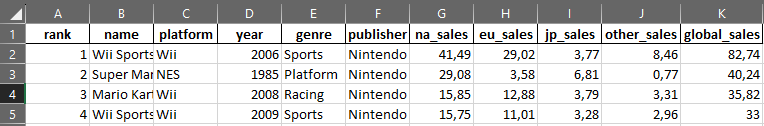

In [8]:
from IPython.display import Image

Image(filename='./img/cleaned_data.png')

# Création d'un onglet Ressources 

Cet onglet est nécessaire pour alimenter les listes de validation dans les filtres. 
Je vais récupérer l'année, le genre, l'éditeur et la console avec la fonction UNIQUE() depuis l'onglet "cleaned_data" dans "Ressources".

In [9]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Vérifier si la feuille existe
if 'Ressources' not in wb.sheetnames:
    # Créer la feuille
       ress_sheet = wb.create_sheet('Ressources')
else :
    ress_sheet = wb['Ressources']


    
#Consoles
list1 = ress_sheet['A1']
formula =  "=_xlfn.UNIQUE(cleaned_data!C:C)"
list1.value = formula 
ress_sheet.formula_attributes['A1'] = {'t': 'array', 'ref': "A1:A32"}

#Année 
list2 = ress_sheet['B1']
formula = "=_xlfn.SORT(_xlfn.UNIQUE(cleaned_data!D:D))"
list2.value= formula
ress_sheet.formula_attributes['B1'] = {'t': 'array', 'ref': "B1:B39"}

#Genre
list3 = ress_sheet['C1']
formula = "=_xlfn.UNIQUE(cleaned_data!E:E)"
list3.value = formula 
ress_sheet.formula_attributes['C1'] = {'t': 'array', 'ref': "C1:C13"}

#Editeur 
list4 = ress_sheet['D1']
formula = "=_xlfn.UNIQUE(cleaned_data!F:F)"
list4.value = formula 
ress_sheet.formula_attributes['D1'] = {'t': 'array', 'ref': "D1:D577"}

# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()


In [10]:
from openpyxl.utils import FORMULAE
"UNIQUE" in FORMULAE

False

La fonction UNIQUE() n'étant pas prise en charge par le package de base openpyxl je dois préfixer les fonctions avec **_xlfn.** pour les rendre utilisables. De même pour SORT().

ress_sheet.formula_attributes['A1'] = {'t': 'array', 'ref': "A1:A32"} 

Cette ligne de code a été le Saint-Graal du projet, elle permet de spécifier qu'une cellule fait référence à un tableau dynamique. Il y a des gros problèmes d'intéraction entre openpyxl et office v365. L'interface a également été totalement changé sur la version 2023. Ainsi, il est possible qu'en fonction de la version que vous utiliserez pour lire mon projet, que le code soit obsolète. 

In [11]:
# votre version d'openpyxl 
import openpyxl
print(openpyxl.__version__)

3.0.10


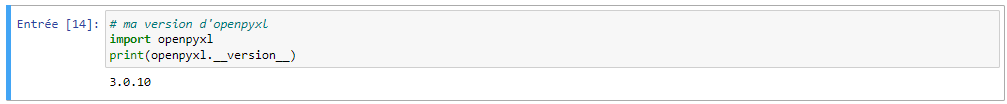

In [12]:
Image('./img/version_openpyxl.png')

# Création du premier dashboard

Ce premier tableau de bord sera un tableau de bord intéractif avec des filtres. Je vais me concentrer sur les ventes totales, les ventes américaines et les ventes en Europe. <br> L'utilisateur aura la possibilité de saisir l'année, le genre et la/les plateforme(s) à observer. Ainsi l'utilisateur pourra consulter un ou des TOP 5 des jeux vendus. <br> Ce tableau de bord contiendra également des informations comme le nombre de jeux sortis ou le nombre de jeux vendus de façon générale, des indicateurs en quelque sorte.

## Création des filtres "Année","Plateforme","Genre"

### Filtre 1 : L'année

In [13]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Vérifier si la feuille existe
if 'TDB_1' not in wb.sheetnames:
    # Créer la feuille
       TDB1_sheet = wb.create_sheet('TDB_1')
        
    
# Nom de l'onglet contenant la liste de validation    
list_sheetname = 'Ressources'
list_sheet = wb[list_sheetname]
TDB1_sheet = wb['TDB_1']

# Retirer la grille 
TDB1_sheet.sheet_view.showGridLines = False 

#Titre du filtre
filter_1_cell = TDB1_sheet['A1']
filter_1_cell.value = 'Année'
filter_1_cell.alignment  = Alignment(horizontal='center', vertical='center')

# Changer la couleur de la cellule
filter_1_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

## Fusionner les cellules A1,A2,B1,B2
TDB1_sheet.merge_cells(start_row=1, start_column=1, end_row=2, end_column=2)

# Créer une liste de validation de données en donnant les valeurs de la colonne B 
# On commence à 1 car la colonne est trier
# Taille de 39 pour ne pas prendre en compte le 0 et l'entête "year" de la fin
formula = '{0}!$B$1:$B${1}'.format(quote_sheetname(list_sheetname), 39)
dv = DataValidation(type='list', formula1=formula)


# Valeur du filtre 
val_filter_1_cell = TDB1_sheet['C1']
val_filter_1_cell.value = 2009 #valeur par défaut, l'utilisateur pourra la changer 
val_filter_1_cell.alignment  = Alignment(horizontal='center', vertical='center')

# Changer la couleur de la cellule
val_filter_1_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')


#Ajouter la liste de validation 
TDB1_sheet.add_data_validation(dv)

## Fusionner les cellules C1,C2,D1,D2
TDB1_sheet.merge_cells(start_row=1, start_column=3, end_row=2, end_column=4)

# Select de la cellule G1 et on applique la validation
col_idx, row_idx = 3, 1
coord = '{}{}'.format(openpyxl.utils.get_column_letter(col_idx), row_idx)
dv.add(coord)

# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()

Quelques explications sur le code et les fonctions utilisées, je crée un filtre en C1 en utilisant de la validation de données. J'utilise une liste de validation à partir du fichier Ressources et de la colonne année avec une formule et la fonction DataValidation().<br> J'applique également du style aux cellules en les fusionnant ou en changeant leur couleur avec les fonctions merge_cells() et PatternFill()

### Filtre 2 : La plateforme

Il y aura deux filtres plateformes, de cette façon il sera possible de faire des tableaux comparatifs. 

In [14]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')


# Nom de l'onglet contenant la liste de validation
list_sheetname = 'Ressources'

# Sélectionner les onglets 
list_sheet = wb[list_sheetname]
TDB1_sheet = wb['TDB_1']


#Titre du filtre
filter_2_cell = TDB1_sheet['E1']
filter_2_cell.value = 'Plateforme'
filter_2_cell.alignment  = Alignment(horizontal='center', vertical='center')

# Changer la couleur de la cellule
filter_2_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=1, start_column=5, end_row=2, end_column=6)



# Créer une liste de validation de données en donnant les valeurs de la colonne A 
# On commence à 2 pour skip l'entête
# Taille de 32 pour ne pas prendre en compte le 0 de la fin
formula = '{0}!$A$2:$A${1}'.format(quote_sheetname(list_sheetname), 32)
dv = DataValidation(type='list', formula1=formula)


# Valeur du filtre 1
val_filter_2_cell = TDB1_sheet['G1']
val_filter_2_cell.value = 'PS3' #valeur par défaut, l'utilisateur pourra la changer 
val_filter_2_cell.alignment  = Alignment(horizontal='center', vertical='center')



# Valeur du filtre 2
val_filter_22_cell = TDB1_sheet['G3']
val_filter_22_cell.value = 'X360' #valeur par défaut, l'utilisateur pourra la changer 
val_filter_22_cell.alignment  = Alignment(horizontal='center', vertical='center')

# Changer la couleur des cellules
val_filter_2_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')
val_filter_22_cell.fill = PatternFill(start_color='F2F2F2', end_color='F2F2F2', fill_type='solid')

#Ajouter la liste de validation 
TDB1_sheet.add_data_validation(dv)

## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=1, start_column=7, end_row=2, end_column=8)
TDB1_sheet.merge_cells(start_row=3, start_column=7, end_row=4, end_column=8)

# Select de la cellule G1 et on applique la validation
col_idx, row_idx = 7, 1
coord = '{}{}'.format(openpyxl.utils.get_column_letter(col_idx), row_idx)
dv.add(coord)

# Select de la cellule G3 et on applique la validation
col_idx, row_idx = 7, 3
coord = '{}{}'.format(openpyxl.utils.get_column_letter(col_idx), row_idx)
dv.add(coord)

# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()

### Filtre 3 : Le genre 

In [15]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Nom de l'onglet contenant la liste de validation
list_sheetname = 'Ressources'

# Sélectionner l'onglet contenant la liste de validation
list_sheet = wb[list_sheetname]
TDB1_sheet = wb['TDB_1']

#Titre du filtre
filter_3_cell = TDB1_sheet['I1']
filter_3_cell.value = 'Genre'
filter_3_cell.alignment  = Alignment(horizontal='center', vertical='center')

# Changer la couleur de la cellule
filter_3_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=1, start_column=9, end_row=2, end_column=10)

# Créer une liste de validation de données en donnant les valeurs de la colonne C 
# On commence à 2 pour skip l'entête et on retire 1 pour ne pas inclure le 0
formula = '{0}!$C$2:$C${1}'.format(quote_sheetname(list_sheetname), 13)
dv = DataValidation(type='list', formula1=formula)

# Style de la cellule filtre
val_filter_3_cell = TDB1_sheet['K1']
val_filter_3_cell.value = 'Shooter' 
val_filter_3_cell.alignment = Alignment(horizontal='center', vertical='center')
val_filter_3_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

#Ajouter la liste de validation 
TDB1_sheet.add_data_validation(dv)


TDB1_sheet.merge_cells(start_row=1, start_column=11, end_row=2, end_column=12)

col_idx, row_idx = 11, 1
coord = '{}{}'.format(openpyxl.utils.get_column_letter(col_idx), row_idx)
dv.add(coord)


wb.save('Dashboards.xlsx')
wb.close()

### Les bordures 

In [16]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

#Style des bordures 
thin = Side(border_style="thin", color="4D4D4D")

# Parcourir les cellules dans la plage spécifiée
for row in TDB1_sheet.iter_rows(min_row=1, max_row=2, min_col=1, max_col=12):
    for cell in row:
        if cell.row == 2:
            cell.border = Border(bottom=thin)
            
        else:
            cell.border = None
# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()

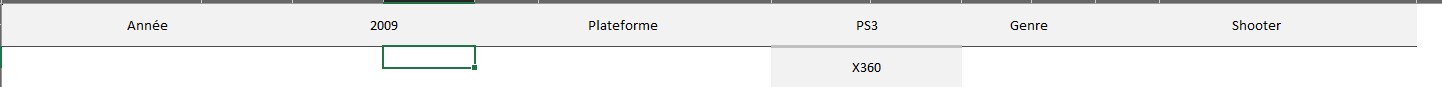

In [17]:
from IPython.display import Image

Image(filename='./img/filters.png')

Voici un aperçu du rendu, les filtres sont maintenant terminés.  

## Création des tableaux

### Premier tableau

Je vais créer un tableau avec un top 5 des jeux les plus vendus, ce tableau est dynamique au niveau des titres et de son contenu, les informations affichées dépendent de la saisie des filtres. 

In [18]:

wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#Titre dynamique
title_cell = TDB1_sheet['A5']
formula = f'="Les meilleurs jeux sur " & G1 & " en " & C1'
title_cell.value = formula
title_cell.alignment  = Alignment(horizontal='center', vertical='center')
title_cell.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')
## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=5, start_column=1, end_row=5, end_column=4)

#Tableau1
sheet = "cleaned_data"
## Nom
col_1_cell = TDB1_sheet['A6']
col_1_cell.value = "Nom"
col_1_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes Totales
col_2_cell = TDB1_sheet['B6']
col_2_cell.value = 'Ventes Totales'
col_2_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes NA
col_3_cell = TDB1_sheet['C6']
col_3_cell.value = 'Ventes NA'
col_3_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes EU 
col_4_cell = TDB1_sheet['D6']
col_4_cell.value = 'Ventes EU'
col_4_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')


#JEU 1 
val_col_1 = TDB1_sheet['A7']
formula_2 =  f'= INDEX({sheet}!$B:$B, MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K), 1),IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1), {sheet}!$K:$K), 0))'
val_col_1.value = formula_2
TDB1_sheet.formula_attributes['A7'] = {'t': 'array', 'ref': "A7:A7"}

#JEU 2
val_col_1_2 = TDB1_sheet['A8']
formula_3 =  f'= INDEX({sheet}!$B:$B, MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K), 2),IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1), {sheet}!$K:$K), 0))'
val_col_1_2.value = formula_3
TDB1_sheet.formula_attributes['A8'] = {'t': 'array', 'ref': "A8:A8"}

#JEU 3
val_col_1_3 = TDB1_sheet['A9']
formula_4 =  f'= INDEX({sheet}!$B:$B, MATCH(LARGE(IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K), 3),IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1), {sheet}!$K:$K), 0))'
val_col_1_3.value = formula_4
TDB1_sheet.formula_attributes['A9'] = {'t': 'array', 'ref': "A9:A9"}

#JEU 4
val_col_1_4 = TDB1_sheet['A10']
formula_5 =  f'= INDEX({sheet}!$B:$B, MATCH(LARGE(IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K), 4),IF(( {sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1), {sheet}!$K:$K), 0))'
val_col_1_4.value = formula_5
TDB1_sheet.formula_attributes['A10'] = {'t': 'array', 'ref': "A10:A10"}

#JEU 5
val_col_1_5 = TDB1_sheet['A11']
formula_6 =  f'= INDEX({sheet}!$B:$B, MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K), 5),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1), {sheet}!$K:$K), 0))'
val_col_1_5.value = formula_6
TDB1_sheet.formula_attributes['A11'] = {'t': 'array', 'ref': "A11:A11"}

# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()

On passe aux autres formules pour récupérer les ventes totales, aux USA et en Europe. Après l'avoir fait la première fois à la main on passe sur une boucle pour gagner du temps. 

In [19]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

# Ventes tot
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=2)
    formule = f'=INDEX({sheet}!$K:$K,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['B'+str(6+i)] = {'t' : 'array', 'ref': 'B'+str(6+i)+':B'+str(6+i)}
    
# Ventes US
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=3)
    formule = f'=INDEX({sheet}!$G:$G,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['C'+str(6+i)] = {'t' : 'array', 'ref': 'C'+str(6+i)+':C'+str(6+i)}
# Ventes EU
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=4)
    formule = f'=INDEX({sheet}!$H:$H,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['D'+str(6+i)] = {'t' : 'array', 'ref': 'D'+str(6+i)+':D'+str(6+i)}
# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()


###  Second Tableau 

In [20]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#Titre dynamique
title_cell = TDB1_sheet['F5']
formula = f'="Les meilleurs "&K1 &" sur " & G1 & " en " & C1'
title_cell.value = formula
title_cell.alignment  = Alignment(horizontal='center', vertical='center')
title_cell.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')
## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=5, start_column=6, end_row=5, end_column=9)

#Tableau2
sheet = "cleaned_data"
## Nom
col_1_cell = TDB1_sheet['F6']
col_1_cell.value = "Nom"
col_1_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes Totales
col_2_cell = TDB1_sheet['G6']
col_2_cell.value = 'Ventes Totales'
col_2_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes NA
col_3_cell = TDB1_sheet['H6']
col_3_cell.value = 'Ventes NA'
col_3_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes EU 
col_4_cell = TDB1_sheet['I6']
col_4_cell.value = 'Ventes EU'
col_4_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')



# Nom
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=6)
    formule = f'=INDEX({sheet}!$B:$B,MATCH(LARGE(IF((cleaned_data!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['F'+str(6+i)] = {'t' : 'array', 'ref': 'F'+str(6+i)+':F'+str(6+i)}
    
# Ventes tot
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=7)
    formule = f'=INDEX({sheet}!$K:$K,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['G'+str(6+i)] = {'t' : 'array', 'ref': 'G'+str(6+i)+':G'+str(6+i)}
    
# Ventes US
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=8)
    formule = f'=INDEX({sheet}!$G:$G,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['H'+str(6+i)] = {'t' : 'array', 'ref': 'H'+str(6+i)+':H'+str(6+i)}
    
# Ventes EU
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=6+i, column=9)
    formule = f'=INDEX({sheet}!$H:$H,MATCH(LARGE(IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$1)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['I'+str(6+i)] = {'t' : 'array', 'ref': 'I'+str(6+i)+':I'+str(6+i)}
    
# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()



### Troisième tableau

In [21]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#Titre dynamique
title_cell = TDB1_sheet['F15']
formula = f'="Les meilleurs "&K1 &" sur " & G3 & " en " & C1'
title_cell.value = formula
title_cell.alignment  = Alignment(horizontal='center', vertical='center')
title_cell.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')
## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=15, start_column=6, end_row=15, end_column=9)

#Tableau3
sheet = "cleaned_data"

## Nom
col_1_cell = TDB1_sheet['F16']
col_1_cell.value = "Nom"
col_1_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes Totales
col_2_cell = TDB1_sheet['G16']
col_2_cell.value = 'Ventes Totales'
col_2_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes NA
col_3_cell = TDB1_sheet['H16']
col_3_cell.value = 'Ventes NA'
col_3_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes EU 
col_4_cell = TDB1_sheet['I16']
col_4_cell.value = 'Ventes EU'
col_4_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')



# Nom
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=6)
    formule = f'=INDEX({sheet}!$B:$B,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['F'+str(16+i)] = {'t' : 'array', 'ref': 'F'+str(16+i)+':F'+str(16+i)}
    
# Ventes tot
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=7)
    formule = f'=INDEX({sheet}!$K:$K,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['G'+str(16+i)] = {'t' : 'array', 'ref': 'G'+str(16+i)+':G'+str(16+i)}
    
# Ventes US
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=8)
    formule = f'=INDEX({sheet}!$G:$G,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['H'+str(16+i)] = {'t' : 'array', 'ref': 'H'+str(16+i)+':H'+str(16+i)}
    
# Ventes EU
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=9)
    formule = f'=INDEX({sheet}!$H:$H,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1)*({sheet}!$E:$E=$K$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['I'+str(16+i)] = {'t' : 'array', 'ref': 'I'+str(16+i)+':I'+str(16+i)}
    
# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()

### Quatrième tableau

In [22]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#Titre dynamique
title_cell = TDB1_sheet['A15']
formula = f'="Les meilleurs jeux sur " & G3 & " en " & C1'
title_cell.value = formula
title_cell.alignment  = Alignment(horizontal='center', vertical='center')
title_cell.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')
## Fusionner les cellules 
TDB1_sheet.merge_cells(start_row=15, start_column=1, end_row=15, end_column=4)

#Tableau4
sheet = "cleaned_data"

## Nom
col_1_cell = TDB1_sheet['A16']
col_1_cell.value = "Nom"
col_1_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes Totales
col_2_cell = TDB1_sheet['B16']
col_2_cell.value = 'Ventes Totales'
col_2_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes NA
col_3_cell = TDB1_sheet['C16']
col_3_cell.value = 'Ventes NA'
col_3_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')

## Ventes EU 
col_4_cell = TDB1_sheet['D16']
col_4_cell.value = 'Ventes EU'
col_4_cell.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')



# Nom
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=1)
    formule = f'=INDEX({sheet}!$B:$B,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['A'+str(16+i)] = {'t' : 'array', 'ref': 'A'+str(16+i)+':A'+str(16+i)}
    
# Ventes tot
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=2)
    formule = f'=INDEX({sheet}!$K:$K,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['B'+str(16+i)] = {'t' : 'array', 'ref': 'B'+str(16+i)+':B'+str(16+i)}
    
# Ventes US
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=3)
    formule = f'=INDEX({sheet}!$G:$G,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['C'+str(16+i)] = {'t' : 'array', 'ref': 'C'+str(16+i)+':C'+str(16+i)}
    
# Ventes EU
for i in range(1, 6):
    cell = TDB1_sheet.cell(row=16+i, column=4)
    formule = f'=INDEX({sheet}!$H:$H,MATCH(LARGE(IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),{i}),IF(({sheet}!$C:$C=$G$3)*({sheet}!$D:$D=$C$1),{sheet}!$K:$K),0))'
    cell.value = formule
    TDB1_sheet.formula_attributes['D'+str(16+i)] = {'t' : 'array', 'ref': 'D'+str(16+i)+':D'+str(16+i)}
    
# Sauvegarder le fichier 
wb.save('Dashboards.xlsx')
wb.close()


### Tableaux Indicateurs filtre 1

Les valeurs de chaque cellule sont des formules Excel qui comptent ou additionnent les données du fichier "cleaned_data.xlsx" en fonction des critères spécifiés dans les arguments de la fonction COUNTIFS() ou SUMIFS(). De cette façon, je crée des indicateurs génériques pour l'utilisateur final. 

In [23]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#cellules gauche haut
cell_title_1 = TDB1_sheet['L5']
cell_title_1.value  = f'="Nombre de jeux sortis sur " &G1 &" en " &C1'
TDB1_sheet.merge_cells(start_row=5, start_column=12, end_row=6, end_column=12)
cell_title_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_1.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')

cell_value_1 = TDB1_sheet['L7']
cell_value_1.value = f'=COUNTIFS(cleaned_data!$D:$D,$C$1,cleaned_data!$C:$C,$G$1)'
TDB1_sheet.merge_cells(start_row=7, start_column=12, end_row=8, end_column=12)
cell_value_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_1.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')
cell_value_1.font = Font(size=14)

#cellules droite haut
cell_title_2 = TDB1_sheet['M5']
cell_title_2.value  = f'="Nombre de jeux de type " &K1 &" sortis sur " &G1 &" en " &C1'
TDB1_sheet.merge_cells(start_row=5, start_column=13, end_row=6, end_column=13)
cell_title_2.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_2.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')
                      
cell_value_2 = TDB1_sheet['M7']
cell_value_2.value = f'=COUNTIFS(cleaned_data!$D:$D,$C$1, cleaned_data!$C:$C,$G$1,cleaned_data!$E:$E,$K$1)'
TDB1_sheet.merge_cells(start_row=7, start_column=13, end_row=8, end_column=13)
cell_value_2.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_2.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')
cell_value_2.font = Font(size=14)

#cellules gauche bas
cell_title_3 = TDB1_sheet['L9']
cell_title_3.value = f'="Nombre de jeux vendus sur " &G1 &" en " &C1'
TDB1_sheet.merge_cells(start_row=9, start_column=12, end_row=10, end_column=12)
cell_title_3.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_3.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')

cell_value_3 = TDB1_sheet['L11']
cell_value_3.value = f'=SUMIFS(cleaned_data!$H:$H, cleaned_data!$D:$D, $C$1, cleaned_data!$C:$C, $G$1) & "M"'
TDB1_sheet.merge_cells(start_row=11, start_column=12, end_row=12, end_column=12)
cell_value_3.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_3.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')
cell_value_3.font = Font(size=14)

#cellules droite bas
cell_title_4 = TDB1_sheet['M9']
cell_title_4.value = f'="Nombre de jeux de type " &K1 &" vendus sur " &G1 &" en " &C1'
TDB1_sheet.merge_cells(start_row=9, start_column=13, end_row=10, end_column=13)
cell_title_4.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_4.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')

cell_value_4 = TDB1_sheet['M11']
cell_value_4.value = f'=SUMIFS(cleaned_data!$H:$H, cleaned_data!$D:$D, $C$1, cleaned_data!$C:$C, $G$1, cleaned_data!$E:$E, $K$1) & "M"' 
TDB1_sheet.merge_cells(start_row=11, start_column=13, end_row=12, end_column=13)
cell_value_4.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_4.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')
cell_value_4.font = Font(size=14)

wb.save('Dashboards.xlsx')
wb.close()


### Tableaux Indicateurs filtre 2

C'est un copié collé du tableau précédent, je pense juste à modifier les paramètres (G1 -> G3) et je fais +10 aux numéros de ligne pour qu'il soit à la bonne place.

In [24]:
# Ouvrir le fichier
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']


#cellules gauche haut
cell_title_1 = TDB1_sheet['L15']
cell_title_1.value  = f'="Nombre de jeux sortis sur " &G3 &" en " &C1'
TDB1_sheet.merge_cells(start_row=15, start_column=12, end_row=16, end_column=12)
cell_title_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_1.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')

cell_value_1 = TDB1_sheet['L17']
cell_value_1.value = f'=COUNTIFS(cleaned_data!$D:$D,$C$1,cleaned_data!$C:$C,$G$3)'
TDB1_sheet.merge_cells(start_row=17, start_column=12, end_row=18, end_column=12)
cell_value_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_1.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')
cell_value_1.font = Font(size=14)

#cellules droite haut
cell_title_2 = TDB1_sheet['M15']
cell_title_2.value  = f'="Nombre de jeux de type " &K1 &" sortis sur " &G3 &" en " &C1'
TDB1_sheet.merge_cells(start_row=15, start_column=13, end_row=16, end_column=13)
cell_title_2.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_2.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')
                      
cell_value_2 = TDB1_sheet['M17']
cell_value_2.value = f'=COUNTIFS(cleaned_data!$D:$D,$C$1, cleaned_data!$C:$C,$G$3,cleaned_data!$E:$E,$K$1)'
TDB1_sheet.merge_cells(start_row=17, start_column=13, end_row=18, end_column=13)
cell_value_2.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_2.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')
cell_value_2.font = Font(size=14)

#cellules gauche bas
cell_title_3 = TDB1_sheet['L19']
cell_title_3.value = f'="Nombre de jeux vendus sur " &G3 &" en " &C1'
TDB1_sheet.merge_cells(start_row=19, start_column=12, end_row=20, end_column=12)
cell_title_3.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_3.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')

cell_value_3 = TDB1_sheet['L21']
cell_value_3.value = f'=SUMIFS(cleaned_data!$H:$H, cleaned_data!$D:$D, $C$1, cleaned_data!$C:$C, $G$3) & "M"'
TDB1_sheet.merge_cells(start_row=21, start_column=12, end_row=22, end_column=12)
cell_value_3.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_3.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')
cell_value_3.font = Font(size=14)

#cellules droite bas
cell_title_4 = TDB1_sheet['M19']
cell_title_4.value = f'="Nombre de jeux de type " &K1 &" vendus sur " &G3 &" en " &C1'
TDB1_sheet.merge_cells(start_row=19, start_column=13, end_row=20, end_column=13)
cell_title_4.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_4.fill = PatternFill(start_color='C4D79B', end_color='C4D79B', fill_type='solid')

cell_value_4 = TDB1_sheet['M21']
cell_value_4.value = f'=SUMIFS(cleaned_data!$H:$H, cleaned_data!$D:$D, $C$1, cleaned_data!$C:$C, $G$3, cleaned_data!$E:$E, $K$1) & "M"' 
TDB1_sheet.merge_cells(start_row=21, start_column=13, end_row=22, end_column=13)
cell_value_4.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_4.fill = PatternFill(start_color='EBF1DE', end_color='EBF1DE', fill_type='solid')
cell_value_4.font = Font(size=14)

wb.save('Dashboards.xlsx')
wb.close()

### Ajuster la taille des colonnes 

In [25]:
from openpyxl.utils import get_column_letter

# Ouvrir le classeur Excel
wb = openpyxl.load_workbook('dashboards.xlsx')

# Sélectionner la feuille de calcul
sheet = wb['TDB_1']


for col in range(1, 10):
    column_letter = get_column_letter(col)
    for row in range(5, 22):
        cell = sheet[f"{column_letter}{row}"]
        if row == 5 or row == 15:
            cell.alignment = Alignment(horizontal = 'center',vertical = 'center',wrap_text = False)
        else : 
            cell.alignment = Alignment(horizontal='left', vertical='center', wrap_text=False)
    sheet.column_dimensions[column_letter].auto_size = True
    
for col in range(13, 14):
    column_letter = get_column_letter(col)
    sheet.column_dimensions[column_letter].auto_size = True

# Enregistrer les modifications et fermer le classeur
wb.save('Dashboards.xlsx')
wb.close()

la méthode auto_size ne semble pas très bien fonctionné sur openpyxl, il y a plein de postes d'utilisateurs avec le même problème sur stackoverflow. Il faut soit modifier la taille de façon expérimentale par du code, soit laisser l'utilisateur double cliquer pour avoir la bonne taille. 

https://stackoverflow.com/questions/71139718/openpyxl-autosize-column-size
https://stackoverflow.com/questions/39529662/python-automatically-adjust-width-of-an-excel-files-columns

### Graphiques TOP 5 des ventes de jeux

La cellule suivante permet de créer les deux graphiques des TOP5. J'utilise des barcharts classiques, ils permettent de visualiser l'information rapidement et simplement. Les données des graphiques correspondent aux tableaux calculés précédemment, ils sont donc également dynamiques et change en fonction des paramètres saisis par l'utilisateur dans le fichier Excel. 

In [37]:
from openpyxl.chart import BarChart, Reference, Series
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

## Premier graph

chart_filter_1 = BarChart()
chart_filter_1.type = "bar"
chart_filter_1.style = 11
chart_filter_1.title = "Top 5 des jeux vendus filtre 1"
chart_filter_1.y_axis.title = 'Nb jeux vendus (en millions)'

data = Reference(TDB1_sheet, min_col=2, min_row=6, max_row=11, max_col=4)

cats = Reference(TDB1_sheet, min_col=1, min_row=7, max_row=11)


chart_filter_1.add_data(data, titles_from_data=True)
#Légende
chart_filter_1.set_categories(cats)


#Ajouter le graph
TDB1_sheet.add_chart(chart_filter_1, "A23")


## Deuxième graph

chart_filter_2 = BarChart()
chart_filter_2.type = "bar"
chart_filter_2.style = 13
chart_filter_2.title = "Top 5 des jeux vendus filtre 2"
chart_filter_2.y_axis.title = 'Nb jeux vendus (en millions)'

data = Reference(TDB1_sheet, min_col=2, min_row=16, max_row=21, max_col=4)

cats = Reference(TDB1_sheet, min_col=1, min_row=17, max_row=21)


chart_filter_2.add_data(data, titles_from_data=True)
#Légende
chart_filter_2.set_categories(cats)


#Ajouter le graph
TDB1_sheet.add_chart(chart_filter_2, "F23")





wb.save('Dashboards.xlsx')
wb.close()

Je rencontre un problème avec les styles des graphiques, ils ne sont pas toujours pris en compte à l'ouverture du fichier Excel. Cela se produit souvent lorsque j'insère d'autres graphiques par la suite, je n'ai pas d'explications et je n'en ai pas trouvé. 

# Deuxième tableau de bord

Ce tableau de bord fera office d'exploration de données, il sera composé uniquement de graphique car je vais créer une feuille de calcul séparé pour alimenter ce dernier. (calc_sheet)

Je souhaite également afficher des informations sur les éditeurs de jeux vidéos mais ils sont trop nombreux, je vais donc choisir manuellement les plus intéressants. (à mon sens)

Je vais utiliser les formules NB.SI.ENS() et SOMME.SI.ENS() pour calculer mes données. 

In [27]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Ajouter un onglet à la feuille de calcul si elle n'existe pas 
if 'calc_sheet' not in wb.sheetnames:
    # Créer la feuille
       calc_sheet = wb.create_sheet('calc_sheet')
else :
    calc_sheet = wb['calc_sheet']
    
####### Ajout des années ###############   
year_cell = calc_sheet['A1']
year_cell.value = f'Année'

for i in range(2, 40):
    cell = calc_sheet.cell(row=i, column=1)
    formule = f'=Ressources!B' + str(i)
    cell.value = formule


####### Ventes par année ############### 
tot_sales_cell_per_year = calc_sheet['B1']
tot_sales_cell_per_year.value = f'Ventes'

for i in range(2, 40):
    cell = calc_sheet.cell(row=i, column=2)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!D:D,A'+str(i)+')'
    cell.value = formule

####### Nb jeux sortis par année ############### 
nb_jeux_per_year = calc_sheet['C1']
nb_jeux_per_year.value ='Nombre de jeux'

for i in range(2,40):
    cell = calc_sheet.cell(row=i, column=3)
    formule = f'=COUNTIFS(cleaned_data!B:B,"<>",cleaned_data!D:D,A'+str(i)+')'
    cell.value = formule

    
####### Ajout des genres ###############  
for i in range(1,14):
    cell = calc_sheet.cell(row=i, column=4)
    formule = f'=Ressources!C'+str(i)
    cell.value = formule
    
####### Nb jeux par genre ###############   
nb_jeux_per_genre = calc_sheet['E1']
nb_jeux_per_genre.value = 'Nombre de jeux'

for i in range(2,14):
    cell = calc_sheet.cell(row=i,column=5)
    formule = f'=COUNTIFS(cleaned_data!B:B,"<>",cleaned_data!E:E,D'+str(i)+')'
    cell.value = formule 

####### Ventes par genre ############### 
tot_sales_per_genre = calc_sheet['F1']
tot_sales_per_genre.value = 'Total ventes'

for i in range(2,14):
    cell = calc_sheet.cell(row=i,column=6)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!E:E,D'+str(i)+')'
    cell.value = formule

editeur_title = calc_sheet['G1']
editeur_title.value = 'Editeurs'

####### Ajout des editeurs ############### 
values = ['Activision', 'Nintendo', 'Take-Two Interactive', 'Ubisoft', 'Square Enix', 'Electronic Arts']

for i, value in enumerate(values):
    cell = calc_sheet.cell(row=i+2, column=7)
    cell.value = value
    
####### Nb jeux sortis par édieurs ###############    
nb_jeux_per_publisher = calc_sheet['H1']
nb_jeux_per_publisher.value = 'Nombre de jeux'

for i in range(2,8):
    cell = calc_sheet.cell(row=i,column=8)
    formule = f'=COUNTIFS(cleaned_data!F:F,G'+str(i)+',cleaned_data!B:B,"<>")'
    cell.value = formule

####### Ventes par édieurs ###############
tot_sales_per_publisher = calc_sheet['I1']
tot_sales_per_publisher.value = 'Total ventes'

for i in range(2,8):
    cell = calc_sheet.cell(row=i,column=9)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!F:F,G'+str(i)+')'
    cell.value = formule

wb.save('Dashboards.xlsx')
wb.close()

## Ajout des graphiques dans TDB_2 

Je vais créer un objet "LineChart" qui représente un graphique de type "ligne". Le graphique aura un titre "Evolution des ventes de jeux par année" et une légende pour l'axe Y "Nb jeux vendus (en millions)".

Le graphique sera créé à partir des données situées dans l'onglet "calc_sheet" du fichier Excel. Les données pour l'axe X (l'année) seront extraites de la colonne B (min_col=2, max_col=2) et les données pour l'axe Y (le nombre de jeux vendus) seront extraites de la colonne A (min_col=1).

Ensuite, le code ajoute les données au graphique à l'aide de la méthode "add_data". Il précise également que les titres des données se trouvent dans les cellules du tableau.

Finalement, le graphique est ajouté à l'onglet "TDB_2" à la cellule A16 à l'aide de la méthode "add_chart".

Cette méthode sera ensuite dupliqué aux autres graphiques. 

In [28]:
from openpyxl.chart import LineChart,PieChart
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Ajouter un onglet à la feuille de calcul si elle n'existe pas 
if 'TDB_2' not in wb.sheetnames:
    # Créer la feuille
       TDB2_sheet = wb.create_sheet('TDB_2')
else :
    TDB2_sheet = wb['TDB_2']
    
calc_sheet = wb['calc_sheet']
TDB2_sheet.sheet_view.showGridLines = False 

## Premier graph Evolution du nombre de ventes de jeux par années 

chart1 = LineChart()
chart1.type = "Line Chart"
chart1.style = 11
chart1.title = "Evolution des ventes de jeux par année"
chart1.y_axis.title = 'Nb jeux vendus (en millions)'

#Les x
data = Reference(calc_sheet, min_col=2, min_row=1, max_row=39, max_col=2)
#Les y
cats = Reference(calc_sheet, min_col=1, min_row=2, max_row=39)

#Ajouter les données 
chart1.add_data(data, titles_from_data=True)

#Légende
chart1.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart1, "A16")
wb.save('Dashboards.xlsx')
wb.close()

Je vais créer dans la prochaine cellule tous les graphiques restant, pour gagner un peu de place et de temps le code sera peut-être un peu moins digeste (déjà qu'il ne l'est pas trop)

In [29]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

#sheets
TDB2_sheet = wb['TDB_2']
calc_sheet = wb['calc_sheet']

# ------------------------------ #
##  Graph2 
chart2 = LineChart()
chart2.type = "Line Chart"
chart2.style = 11
chart2.title = "Evolution du nombre de jeux sortis par année"
chart2.y_axis.title = 'Nb jeux sortis'
data = Reference(calc_sheet, min_col=3, min_row=1, max_row=39, max_col=3)
cats = Reference(calc_sheet, min_col=1, min_row=2, max_row=39)
chart2.add_data(data, titles_from_data=True)


#Légende
chart2.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart2, "A1")


# ------------------------------ #
## Graph3 
chart3 = BarChart()
chart3.type = "bar"
chart3.style = 11
chart3.title = "Nombre de jeux par genre"
chart3.y_axis.title = 'Nb jeux sortis'
data = Reference(calc_sheet, min_col=5, min_row=1, max_row=13, max_col=5)
cats = Reference(calc_sheet, min_col=4, min_row=2, max_row=13)
chart3.add_data(data, titles_from_data=True)


#Légende
chart3.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart3, "J1")

# ------------------------------ #
## Graph4
chart4 = BarChart()
chart4.type = "bar"
chart4.style = 11
chart4.title = "Ventes tot. par genre"
chart4.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=6, min_row=1, max_row=13, max_col=6)
cats = Reference(calc_sheet, min_col=4, min_row=2, max_row=13)
chart4.add_data(data, titles_from_data=True)


#Légende
chart4.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart4, "J16")


# ------------------------------ #
## Graph5
chart5 = PieChart()
#chart5.type = "bar"
#chart5.style = 11
chart5.title = "Nombre de jeux sortis par éditeur"
#chart5.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=8, min_row=1, max_row=7, max_col=8)
cats = Reference(calc_sheet, min_col=7, min_row=2, max_row=7)
chart5.add_data(data, titles_from_data=True)

# Ajouter des étiquettes de données
chart5.dataLabels = DataLabelList()
chart5.dataLabels.showPercent = True
chart5.dataLabels.showVal = False

#Légende
chart5.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart5, "S1")

# ------------------------------ #
## Graph6
chart6 = PieChart()
#chart6.type = "Line Chart"
chart6.title = "Nombre de jeux vendus par éditeur"
#chart6.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=9, min_row=1, max_row=7, max_col=9)
cats = Reference(calc_sheet, min_col=7, min_row=2, max_row=7)
chart6.add_data(data, titles_from_data=True)

# Ajouter des étiquettes de données
chart6.dataLabels = DataLabelList()
chart6.dataLabels.showPercent = True
chart6.dataLabels.showVal = False


#Légende
chart6.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart6, "S16")


wb.save('Dashboards.xlsx')
wb.close()

J'utilise un PieChart pour les graphiques 5 et 6, l'idée est de visualiser la "part" des acteurs dans le marché. De cette façon, on peut éventuellement regarder les proportions entre jeux sortis/jeux vendus.

### Difficultés rencontrées 

 J'ai rencontré de grandes difficulté à faire fonctionner ce code, je ne savais pas pourquoi mais parfois des "@" se glisse devant le nom de la feuille "cleaned_data".

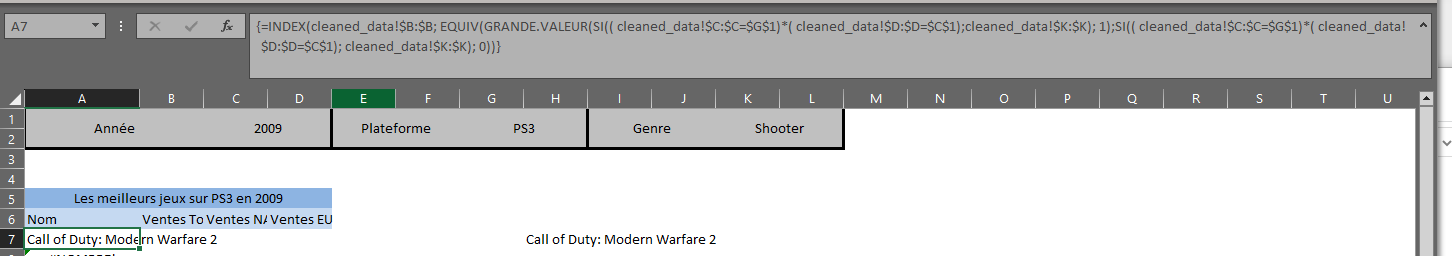

In [30]:
Image(filename='./img/bug_at.png')

Quand la formule fonctionne il rajoute également des "{}" en début et fin de formule qui disparaissent une fois qu'on clique dans la formule. De ce que j'ai pu lire sur Internet, ces accolades montrent que la formule fonctionne comme il faut avec openpyxl et qu'il comprend les références à cleaned_data. Cependant il arrive parfois qu'il ne comprenne pas et rajoute ces fameux "@". Le seul moyen que j'ai trouvé pour limiter ce bug, c'est d'ouvrir le fichier, supprimer les "@" à la main puis relancer le code. Preuve ci dessous. 

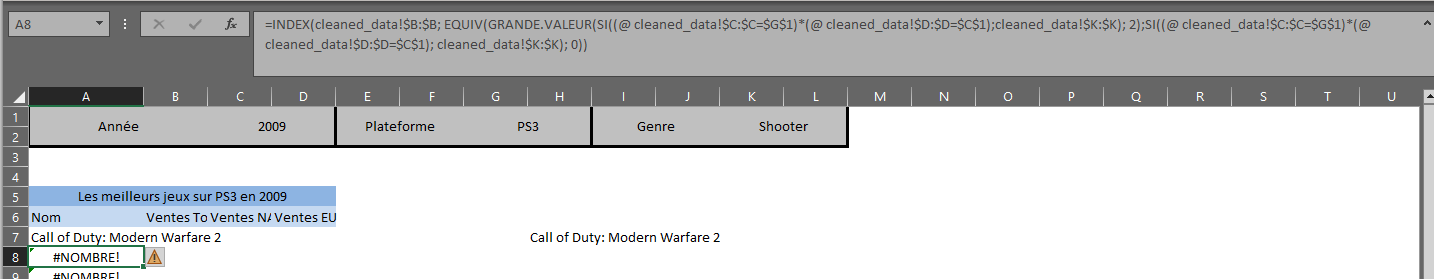

In [31]:
Image(filename='./img/bug_at_2.png')

Il n'y a pas de problème sur la ligne A7 mais sur les lignes du dessous si...  Pourtant, la même formule et le même code est appliqué. <br> Je supprime donc tous les "@" à la main et je relance le code. 

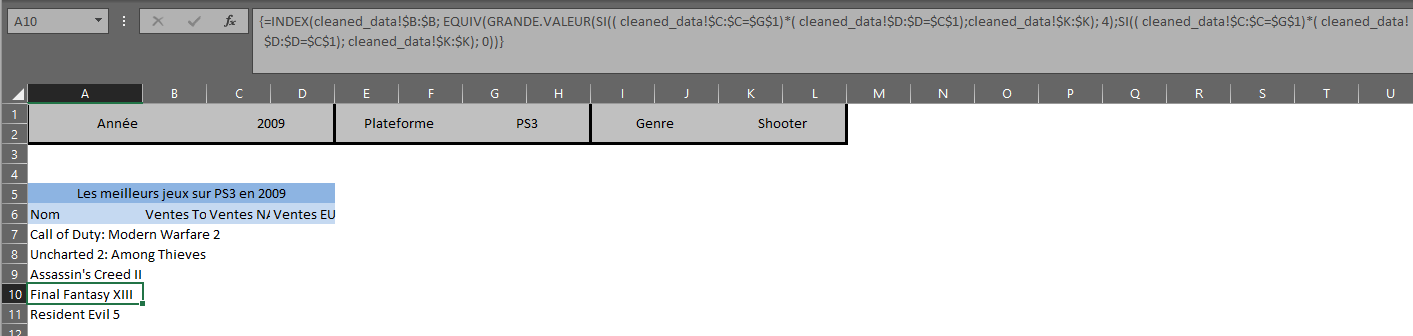

In [32]:
Image(filename='./img/bug_at_3.png')

La formule fonctionne correctement maintenant...

In [33]:
wb = openpyxl.load_workbook('Dashboards.xlsx')

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

cell = TDB1_sheet['C11']
print(cell.value)

=INDEX(cleaned_data!$G:$G,MATCH(LARGE(IF((cleaned_data!$C:$C=$G$1)*(cleaned_data!$D:$D=$C$1),cleaned_data!$K:$K),5),IF((cleaned_data!$C:$C=$G$1)*(cleaned_data!$D:$D=$C$1),cleaned_data!$K:$K),0))


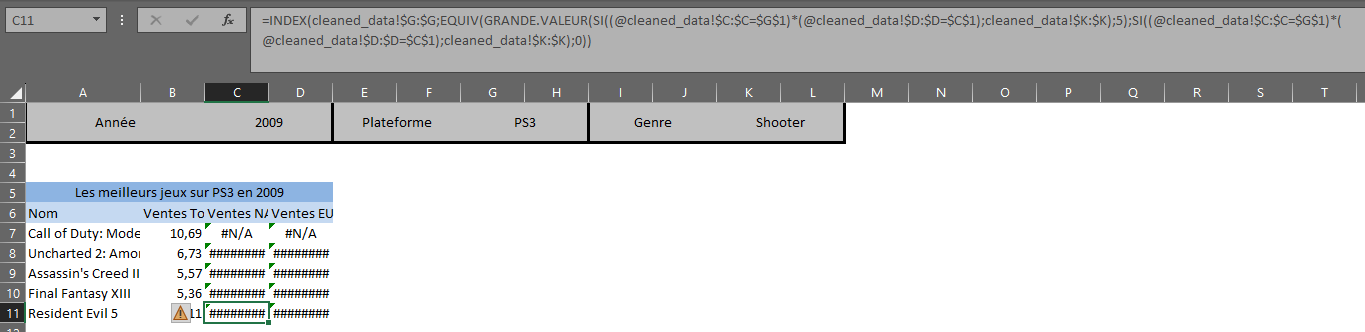

In [34]:
Image('./img/bug_at_4.png')

Par ailleurs il n'est pas possible de récupérer le contenu de la cellule et de supprimer les @ car ils n'apparaissent pas, c'est bien du côté d'Excel qu'il se passe quelquechose.

Après plus d'investigation, ce ne serait pas un bug mais une évolution d'Excel avec office 365. Les @ font référence à la formule SINGLE() permettant de récupérer une valeur dans un array, ils s'insèrent automatiquement et on ne peut les supprimer qu'à la main. Cette évolution fait suite à la création des tableaux dynamiques apportés dans les dernières mises à jour. 

Il faut donc ajouter la fameuse ligne : (en adaptant les lignes/colonnes bien sûr) 

ress_sheet.formula_attributes['A1'] = {'t': 'array', 'ref': "A1:A32"} -> pour afficher les résultats de la formule sur plusieurs ligne 

res_sheet.formula_attributes['A1'] = {'t' : 'array', 'ref': "A1:A1"} -> pour afficher le résultat de la formule dans une seule cellule

Pour qu'openpyxl et Excel fonctionnent correctement. 




Sources pour la résolution <br>
https://support.microsoft.com/en-us/office/implicit-intersection-operator-ce3be07b-0101-4450-a24e-c1c999be2b34?ui=en-us&rs=en-us&ad=us <br>
https://stackoverflow.com/questions/61705150/openpyxl-is-inserted-to-formula-when-saving-to-file<br>
https://stackoverflow.com/questions/66008301/symbol-appearing-after-inserting-if-formula-into-excel-using-openpyxl<br>
https://stackoverflow.com/questions/57298554/how-to-insert-array-formula-in-an-excel-sheet-with-openpyxl/57441549#57441549 <br>
https://techcommunity.microsoft.com/t5/excel/curly-brackets-added-to-formulas-once-workbook-is-copied-and/m-p/1111428 <br>
https://stackoverflow.com/questions/74608700/openpyxl-inserts-in-excel-formulas <br>
https://stackoverflow.com/questions/64827312/excel-adding-signs-in-openpyxl-generated-workbooks <br> 


# Bonus

In [35]:
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from PIL import Image as PILImage

img = PILImage.open("./img/this-is-fine.jpg")
wb = openpyxl.load_workbook('Dashboards.xlsx')

if 'BONUS' not in wb.sheetnames:
    # Créer la feuille
       sheet_image = wb.create_sheet('BONUS')
else :
    sheet_image = wb['BONUS']

# Supprimer la grille
sheet_image.sheet_view.showGridLines = False 
# Supprimer les en-têtes de colonnes de la feuille de calcul
sheet_image.show_headers = False
# Supprimer la barre de formule de la feuille de calcul
sheet_image.show_formulas = False

img_excel = Image(img)
sheet_image.add_image(img_excel, "I3")

wb.save("Dashboards.xlsx")